In [191]:
%matplotlib inline

import math
import json
import codecs

import numpy as np
import pandas as pd
import networkx as nx

from sklearn import preprocessing

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [2]:
g = nx.read_gexf("datasets/influences.philosophersonly.gexf")

In [3]:
df = pd.DataFrame.from_csv("datasets/dates.birthdeath.csv")

df.head(5)

,birthyear,birthdate,deathyear
name,,,
Syed_Abdul_Hakim,1874.0,NaN,1944.0
Moses_ibn_Ezra,1055.0,NaN,1138.0
Francisco_Sanches,1550.0,NaN,1623.0
Sibawayh,760.0,NaN,796.0
Solomon_ibn_Gabirol,1021.0,NaN,1058.0


In [4]:
base = list(set(g.nodes()) & set(df[ df["birthyear"].notnull() | df["deathyear"].notnull() ].index))
g_base = g.subgraph(base)

print len(base)

849


In [5]:
df_base = df.loc[base, ["birthyear", "deathyear"]]

In [6]:
df_base.head()

,birthyear,deathyear
name,,
Bonaventure__Bonaventure__1,1221.0,1274.0
Muhammad_Mustafa_Jauhar,1895.0,1985.0
Leonardo_Polo,1926.0,2013.0
Julian_Savulescu,1963.0,NaN
Francis_Fukuyama,1952.0,NaN


In [7]:
A = nx.to_numpy_matrix(g_base)

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA().fit(A)

In [10]:
Y = pca.transform(A)
Y = zip(*Y)

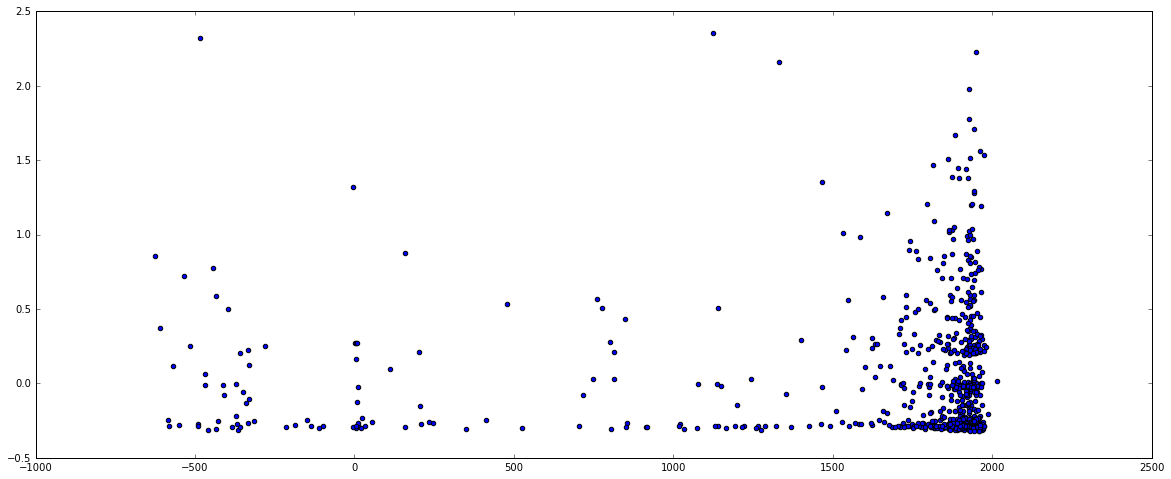

In [11]:
x = list(df_base["birthyear"])
y = Y[0]

time_periods = [[-750, 1000],[1000, 1900],[1900, 2000]]

plt.figure(figsize=(20,8))
plt.scatter(x, y)
plt.show()

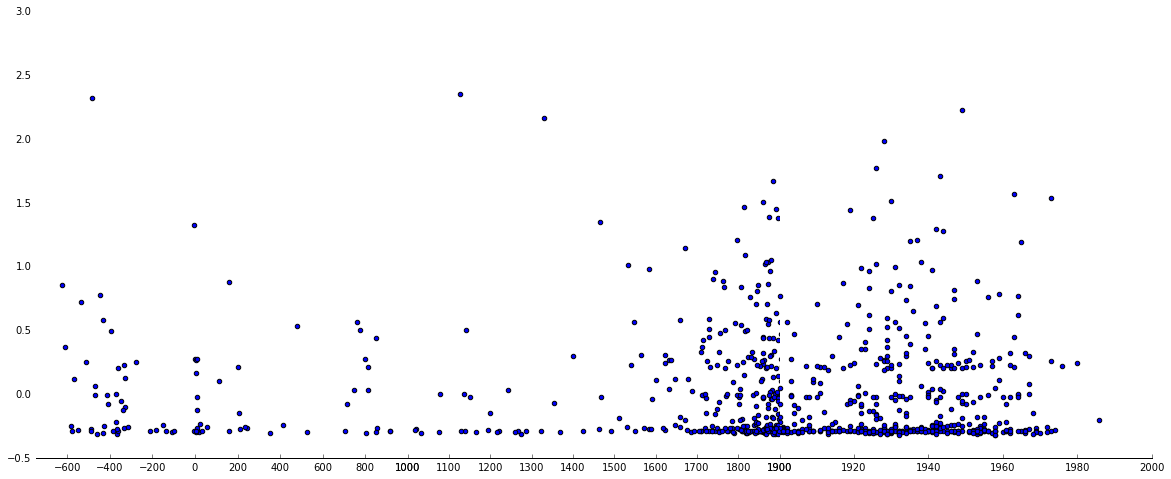

In [12]:
x = list(df_base["birthyear"])
y = Y[0]

time_periods = [[-750, 1000],[1000, 1900],[1900, 2000]]

plt.figure(figsize=(20,8))

f, ax = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(20,8))

for i, time_period in enumerate(time_periods):
  ax[i].scatter(x,y)
  
  ax[i].set_xlim(time_period[0], time_period[1])
  
  ax[i].spines['right'].set_visible(False)
  ax[i].spines['left'].set_visible(False)
  ax[i].spines['top'].set_visible(False)
  ax[i].xaxis.set_ticks_position('bottom') 
  ax[i].yaxis.set_ticks_position('none') 

# f.tight_layout()
f.subplots_adjust(wspace=0)
plt.show()

In [13]:
def colorize(condition):
  if condition:
    return (1,0,0,1)
  else:
    return (.5,.5,.5,.2)

## chronological anomalies

In [14]:
def is_chronological_anomaly(n, g, df):
  # print n
  successors = g.successors(n)
  predecessors = g.predecessors(n)

  condition = False
  
  # check if successors (people that have been given influence)
  for n2 in successors:
    if df.loc[n2, "birthyear"] > df.loc[n, "deathyear"]:
      condition = True
  
  # check if predecessors (people that have received influence)
  for n2 in predecessors:
    if df.loc[n, "birthyear"] > df.loc[n2, "deathyear"]:
      condition = True
  
  return condition

df_base["is chronological anomaly"] = map(lambda n: is_chronological_anomaly(n, g_base, df_base), df_base.index)

In [15]:
print df_base[df_base["is chronological anomaly"] == True].index

Index([u'Plato', u'Georg_Wilhelm_Friedrich_Hegel', u'Abu_Yusuf',
       u'Mirza_Mazhar_Jan-e-Janaan', u'Al-Dhahabi', u'Leucippus',
       u'Blaise_Pascal', u'Proclus', u'Muhammad_al-Shaybani', u'Democritus',
       u'Pseudo-Dionysius_the_Areopagite', u'Yusuf_ibn_Abd_al-Rahman_al-Mizzi',
       u'Homer', u'Zhuang_Zhou', u'Plotinus', u'Burhan_al-Din_al-Marghinani',
       u'Ahmad_Sirhindi', u'Ibn_Abd_al-Hadi', u'Immanuel_Kant', u'Iamblichus',
       u'Predrag_Finci', u'Qadi_Thanaullah_Panipati', u'Laozi'],
      dtype='object', name=u'name')


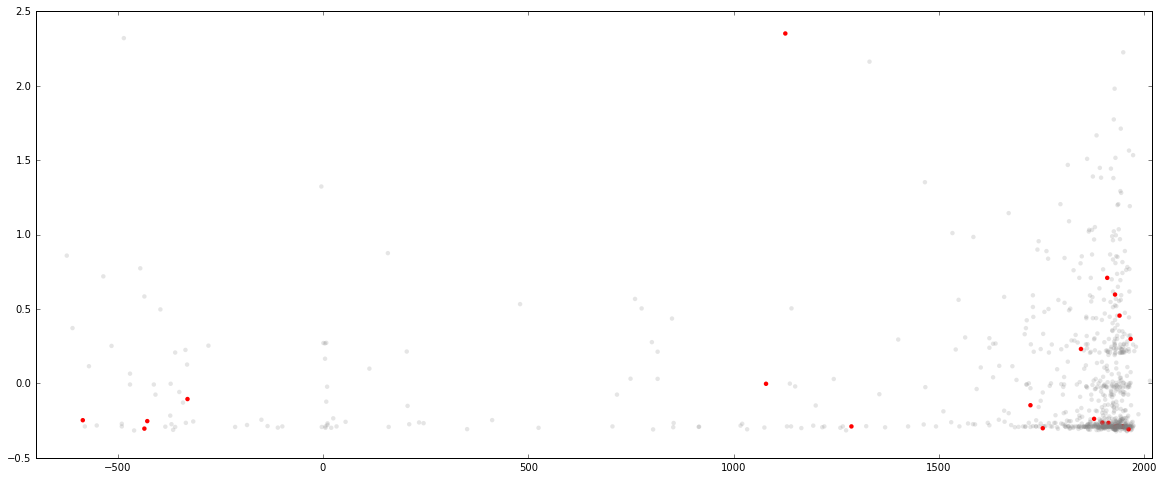

In [16]:
colors = map(colorize, df_base["is chronological anomaly"])
  
plt.figure(figsize=(20,8))
plt.scatter(x, y, lw=0, color=colors)
plt.xlim(-700, 2018)
plt.show()

## demographical anomalies

71.6061643836
15.37096558


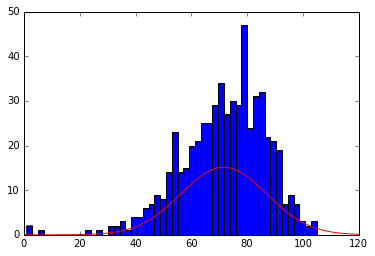

In [17]:
ages = df_base[ df_base["deathyear"].notnull() & df_base["birthyear"].notnull() ]["deathyear"] - df_base[ df_base["deathyear"].notnull() & df_base["birthyear"].notnull()]["birthyear"]
ages = ages[(ages > 0) & (ages < 130)]

mu = ages.mean()
sigma = ages.std()

print mu
print sigma

plt.hist(ages, bins=50)

x = np.linspace(0,120,100)
plt.plot(x,mlab.normpdf(x,mu,sigma)*len(ages), color="red")

plt.show()

In [18]:
def get_prob_normdist(x, mu, sigma):
  return mlab.normpdf(x,mu,sigma)

print get_prob_normdist(0, mu, sigma)
print get_prob_normdist(20, mu, sigma)
print get_prob_normdist(70, mu, sigma)
print get_prob_normdist(80, mu, sigma)
print get_prob_normdist(100, mu, sigma)
print get_prob_normdist(140, mu, sigma)

5.03144714026e-07
9.25818547774e-05
0.0258129662363
0.0223590821353
0.00471237385743
1.30324442075e-06


In [19]:
df_base["age"] = (df_base["birthyear"].notnull() & df_base["deathyear"].notnull()) * (df_base["deathyear"] - df_base["birthyear"])

df_base["is demographical anomaly"] = map(lambda x: get_prob_normdist(x, mu, sigma) < .0001, df_base["age"])
#df_base.loc[ df_base["age"].isnull().index , "is demographical anomaly"] = None

print "error detected: %s" % len(df_base[ df_base["age"].notnull() & df_base["is demographical anomaly"] ])
print df_base[ df_base["age"].notnull() & df_base["is demographical anomaly"] ]["age"]

#df_base.head(20)

error detected: 19
name
Speusippus                               747.0
Abu_Yusuf                                685.0
Philodemus                               150.0
Mirza_Mazhar_Jan-e-Janaan                 -1.0
Ioane_Petritsi                             1.0
Leucippus                                  0.0
David_the_Invincible                       0.0
Sufyan_al-Thawri                        -555.0
Pseudo-Dionysius_the_Areopagite            1.0
Yusuf_ibn_Abd_al-Rahman_al-Mizzi        -672.0
Metrodorus_of_Lampsacus_(the_younger)    609.0
Muhammad_Usman_Damani                    653.0
Burhan_al-Din_al-Marghinani                6.0
Panaetius                                295.0
Arcesilaus                               557.0
Ibn_Abi_Asim                             694.0
Xenocrates                               710.0
Haji_Dost_Muhammad_Qandhari              652.0
Laozi                                     -1.0
Name: age, dtype: float64


In [20]:
print len(df_base[df_base["is chronological anomaly"] == True])
print len(df_base[df_base["is demographical anomaly"] == True])
print len(df_base[df_base["is demographical anomaly"] | df_base["is chronological anomaly"]])

23
19
35


## train a predictor

In [21]:
g_train = g.subgraph(df_base[df_base["birthyear"].notnull() & (df_base["is demographical anomaly"] == False) & (df_base["is chronological anomaly"] == False)].index)
g_test = g.subgraph(df_base[df_base["is demographical anomaly"] | df_base["is chronological anomaly"]].index)

print len(g_train.nodes())
print len(g_test.nodes())

808
35


In [22]:
from sklearn import linear_model

### linear regression

#### using only adjacency matrix

In [198]:
model = linear_model.LinearRegression()

X = nx.to_numpy_matrix(g_train)
Y = list(df_base.loc[ g_train.nodes() , "birthyear"])

model = model.fit(X,Y)

- min max range mean std predecessors and successors
- other models

In [199]:
df_train = df_base[df_base["birthyear"].notnull() & (df_base["is demographical anomaly"] == False) & (df_base["is chronological anomaly"] == False)].copy()

df_train.head(10)

,birthyear,deathyear,is chronological anomaly,age,is demographical anomaly
name,,,,,
Bonaventure__Bonaventure__1,1221.0,1274.0,False,53.0,False
Muhammad_Mustafa_Jauhar,1895.0,1985.0,False,90.0,False
Leonardo_Polo,1926.0,2013.0,False,87.0,False
Julian_Savulescu,1963.0,NaN,False,NaN,False
Francis_Fukuyama,1952.0,NaN,False,NaN,False
Jacques_Ellul,1912.0,1994.0,False,82.0,False
Joseph_Dietzgen,1828.0,1888.0,False,60.0,False
Richard_David_Precht,1964.0,NaN,False,NaN,False
Emil_Fackenheim,1916.0,2003.0,False,87.0,False


In [200]:
df_val = df_base[df_base["birthyear"].notnull() & (df_base["is demographical anomaly"] == False) & (df_base["is chronological anomaly"] == False)].copy()
df_val["predict"] = model.predict(nx.to_numpy_matrix(g_train))

np.mean(np.sqrt((df_val["birthyear"] - df_val["predict"])**2))

348.96220835613047

#### network statistics

In [209]:
def get_sociodemographic_stats(nodes, g, df_source):
  
  cols = [ (c1, c2) for c1 in ["following", "followers"] for c2 in ["count", "birth mean", "birth std", "birth min", "birth max", "death mean", "death std"] ]
  
  df = pd.DataFrame(index=nodes, columns=cols)
  
  for n in nodes:
    following = g.successors(n)
    followers = g.predecessors(n)

    df_following = df_source.loc[ [ n2 for n2 in following if n2 in df_source.index ] ]
    df_followers = df_source.loc[ [ n2 for n2 in followers if n2 in df_source.index ] ]

    df.set_value(n, ("following", "count"), len(following))    
    df.set_value(n, ("following", "birth min"), df_following["birthyear"].min())
    df.set_value(n, ("following", "birth max"), df_following["birthyear"].max())
    df.set_value(n, ("following", "birth mean"), df_following["birthyear"].mean())
    df.set_value(n, ("following", "birth std"), df_following["birthyear"].std())
    df.set_value(n, ("following", "death mean"), df_following["deathyear"].mean())
    df.set_value(n, ("following", "death std"), df_following["deathyear"].std())
    
    df.set_value(n, ("followers", "count"), len(followers))    
    df.set_value(n, ("followers", "birth min"), df_followers["birthyear"].min())
    df.set_value(n, ("followers", "birth max"), df_followers["birthyear"].max())
    df.set_value(n, ("followers", "birth mean"), df_followers["birthyear"].mean())
    df.set_value(n, ("followers", "birth std"), df_followers["birthyear"].std())
    df.set_value(n, ("followers", "death mean"), df_followers["deathyear"].mean())
    df.set_value(n, ("followers", "death std"), df_followers["deathyear"].std())

  return df

get_sociodemographic_stats(g_train.nodes()[0:5], g_train, df_base.loc[g_train.nodes()])

,"(following, count)","(following, birth mean)","(following, birth std)","(following, birth min)","(following, birth max)","(following, death mean)","(following, death std)","(followers, count)","(followers, birth mean)","(followers, birth std)","(followers, birth min)","(followers, birth max)","(followers, death mean)","(followers, death std)"
Muhammad_Mustafa_Jauhar,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
Leonardo_Polo,3,1121.33,1303.74,-384,1889,1197.33,1315.92,0,NaN,NaN,NaN,NaN,NaN,NaN
Julian_Savulescu,1,1946,NaN,1946,1946,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
Francis_Fukuyama,1,1930,NaN,1930,1930,1992,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
Jacques_Ellul,3,1833.67,35.2184,1809,1874,1898.67,43.6616,4,1923.75,4.78714,1918,1929,1993,7.87401


In [246]:
df_all = get_sociodemographic_stats(g.nodes(), g, df)

In [248]:
df_all.to_csv("datasets/demographics.csv", encoding="utf-8")

1071


In [230]:
model = linear_model.LinearRegression(normalize=True)

df_train2 = get_sociodemographic_stats(g_train.nodes(), g_train, df_base.loc[g_train.nodes()])

X = df_train2.fillna(0).as_matrix()
Y = list(df_base.loc[ g_train.nodes() , "birthyear"])

model = model.fit(X,Y)

In [229]:
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [231]:
np.mean(np.sqrt((Y - model.predict(X))**2))

201.11855450580185

In [223]:
df_train2["real"] = df_base.loc[ g_train.nodes() , "birthyear"]
df_train2["predict"] = model.predict(X)

In [224]:
df_train2.head(20)

,"(following, count)","(following, birth mean)","(following, birth std)","(following, birth min)","(following, birth max)","(following, death mean)","(following, death std)","(followers, count)","(followers, birth mean)","(followers, birth std)","(followers, birth min)","(followers, birth max)","(followers, death mean)","(followers, death std)",real,predict
Muhammad_Mustafa_Jauhar,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1895.0,1265.310884
Leonardo_Polo,3,1121.33,1303.74,-384,1889,1197.33,1315.92,0,NaN,NaN,NaN,NaN,NaN,NaN,1926.0,1851.758754
Julian_Savulescu,1,1946,NaN,1946,1946,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1963.0,2016.160907
Francis_Fukuyama,1,1930,NaN,1930,1930,1992,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1952.0,1915.228577
Jacques_Ellul,3,1833.67,35.2184,1809,1874,1898.67,43.6616,4,1923.75,4.78714,1918,1929,1993,7.87401,1912.0,1960.434883
Moses_Mendelssohn,4,1539.5,272.835,1137,1743,1610.75,276.035,3,1798.67,87.0651,1743,1899,1864,94.8736,1729.0,1759.210362
Richard_David_Precht,1,1953,NaN,1953,1953,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1964.0,2018.945183
Emil_Fackenheim,1,1775,NaN,1775,1775,1854,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1916.0,1860.128167
Shibli_Nomani,1,1817,NaN,1817,1817,1898,NaN,2,1928,33.9411,1904,1952,1997,NaN,1857.0,1972.767229
Hent_de_Vries,1,1926,NaN,1926,1926,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1958.0,2008.205833


In [232]:
df_test = get_sociodemographic_stats(g_test.nodes(), g, df)

df_test["predict"] = model.predict(df_test.fillna(0).as_matrix())

df_test["predict"]

Mirza_Mazhar_Jan-e-Janaan                1535.559730
Pseudo-Dionysius_the_Areopagite          1034.760014
Speusippus                               1049.239592
Leucippus                                1208.684162
Muhammad_al-Shaybani                      219.871883
Metrodorus_of_Lampsacus_(the_younger)    1119.304803
Al-Dhahabi                               1311.117836
Abu_Yusuf                                 219.871883
Muhammad_Usman_Damani                    1839.301887
Predrag_Finci                            -235.427220
Haji_Dost_Muhammad_Qandhari              1460.481135
Burhan_al-Din_al-Marghinani              1394.810171
Ioane_Petritsi                           1077.863735
Xenocrates                               1096.686300
Sufyan_al-Thawri                         1318.053080
Plato                                      39.084855
Democritus                               -686.630551
Ahmad_Sirhindi                             83.723431
Panaetius                                1110.